In [1]:
import numpy as np
import scipy.linalg

In [2]:
# ! pip install cvxpy
import cvxpy as cvx

In [3]:
A = np.array([[1, 0.1], [0,1]])
B = np.array([[0],[1]])

Q = np.array([[1, 0], [0, 0.5]])
R = np.array([[1]])

P = scipy.linalg.solve_discrete_are(A, B, Q, R)
K = -np.linalg.inv(R + B.T @ P @ B) @ B.T @ Q @ P @ A

horizon = 10
ulim = 0.5

In [4]:
def optimization_controller(x_curr, H=horizon, terminal=False):
    xs = cvx.Variable((H, A.shape[0]))
    us = cvx.Variable((H, B.shape[1]))
    cost = 0
    for k in range(H):
        cost += cvx.quad_form(xs[k], Q) + cvx.quad_form(us[k], R)
    constr = []
    for k in range(H-1):
        constr += [xs[k+1] == A @ xs[k] + B @ us[k]]
    constr += [xs[0] == x_curr]
    for k in range(H):
        constr += [xs[k,0] <= 1, xs[k,0] >= -1]
        constr += [us[k] <= ulim, us[k] >= -1*ulim]
    if terminal: constr += [xs[-1] == np.array([0,0])]
    problem = cvx.Problem(cvx.Minimize(cost), constr)
    problem.solve()
    if problem.status not in ["infeasible", "unbounded"]:
        return us[0].value
    else:
        return np.nan

def test_feasible(xs, controller):
    init_feasible = []
    always_feasible = []
    for x in xs:
        res = controller(x)
        if np.isnan(res):
            init_feasible.append(False)
            always_feasible.append(False)
        else:
            init_feasible.append(True)
            xtest = x
            while not np.isnan(res) and np.linalg.norm(xtest) >= 0.5:
                xtest = A @ xtest + B @ res
                res = controller(xtest)
            always_feasible.append(not np.isnan(res))
    return init_feasible, always_feasible


In [5]:
x0 = np.array([.5, 2])


xs = {'lqr-clip':[x0], 'lqr':[x0]}
us = {'lqr-clip':[], 'lqr':[]}
horizons = [10, 2]
for H in horizons:
    xs['mpc-{}'.format(H)] = [x0]
    us['mpc-{}'.format(H)] = []
for _ in range(30):
    us['lqr-clip'].append(np.clip(K @ xs['lqr-clip'][-1], -1*ulim, ulim))
    xs['lqr-clip'].append(A @ xs['lqr-clip'][-1] + B @ us['lqr-clip'][-1])
    us['lqr'].append(K @ xs['lqr'][-1])
    xs['lqr'].append(A @ xs['lqr'][-1] + B @ us['lqr'][-1])
    for H in horizons:
        us['mpc-{}'.format(H)].append(np.nan_to_num(optimization_controller(xs['mpc-{}'.format(H)][-1], H=H)).reshape(1))
        xs['mpc-{}'.format(H)].append(A @ xs['mpc-{}'.format(H)][-1] + B @ us['mpc-{}'.format(H)][-1])


for key in xs.keys():
    xs[key] = np.array(xs[key])
    us[key] = np.array(us[key])


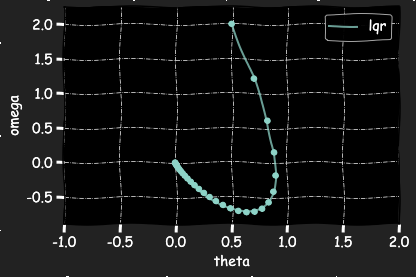

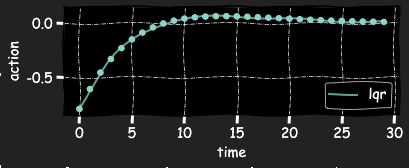

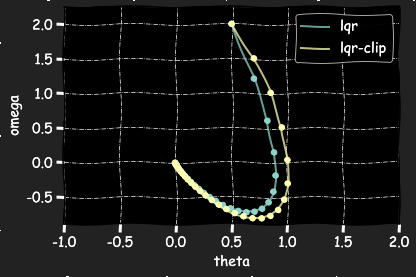

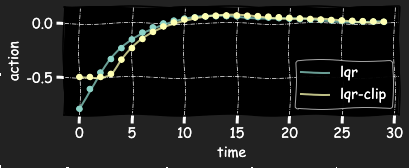

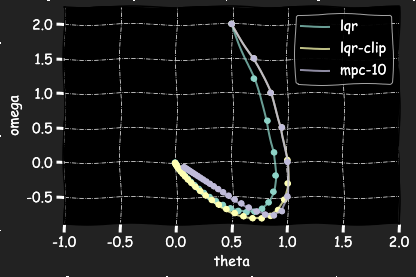

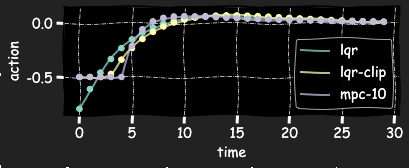

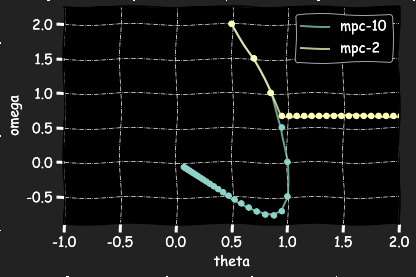

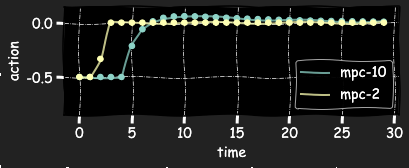

In [9]:
import matplotlib.pyplot as plt
from matplotlib import patheffects

plt.style.use(['dark_background'])
plt.xkcd()
plt.rcParams['path.effects'] = [patheffects.withStroke(linewidth=0)]

plt.rcParams['figure.facecolor'] = '#222222'


c='white'

def make_plots(keylist):
    plt.figure()
    # c='black'
    # for xs, c in zip(xs_list, colors):
    for key in keylist:
        plt.plot(xs[key][:,0], xs[key][:,1], alpha=0.75, linewidth=2, label=key)
        plt.plot(xs[key][:,0], xs[key][:,1], '.', color=plt.gca().lines[-1].get_color(), markersize=10)
    # plt.grid(color=c)
    plt.grid(color=c, linestyle='-.', linewidth=0.7)
    plt.ylabel('omega')
    plt.xlabel('theta')
    plt.legend()
    # plt.axis('equal');
    plt.xlim([-1, 2])
    plt.ylim([-0.9, 2.25])

    plt.figure(figsize=[6, 2])
    for key in keylist:
        plt.plot(us[key], alpha=0.75, linewidth=2, label=key)
        plt.plot(us[key], '.', color=plt.gca().lines[-1].get_color(), markersize=10)
    plt.grid(color=c, linestyle='-.', linewidth=0.7)
    plt.ylabel('action')
    plt.xlabel('time')
    plt.legend()
    plt.ylim([-0.85, 0.15])
    plt.show()

make_plots(['lqr'])
make_plots(['lqr', 'lqr-clip'])
make_plots(['lqr', 'lqr-clip', 'mpc-10'])
make_plots(['mpc-10', 'mpc-2'])